<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/PredictStockRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [2]:
#import packages
from IPython.display import display
import pandas as pd
import numpy as np

import datetime as dt
import pandas_datareader.data  as pdr

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

sns.set()
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.2)

Using TensorFlow backend.


In [0]:
ticker = "AAPL"
end_date = dt.date.today()
start_date = end_date - dt.timedelta(365 * 5)
data = pdr.get_data_yahoo(ticker, start_date, end_date) 

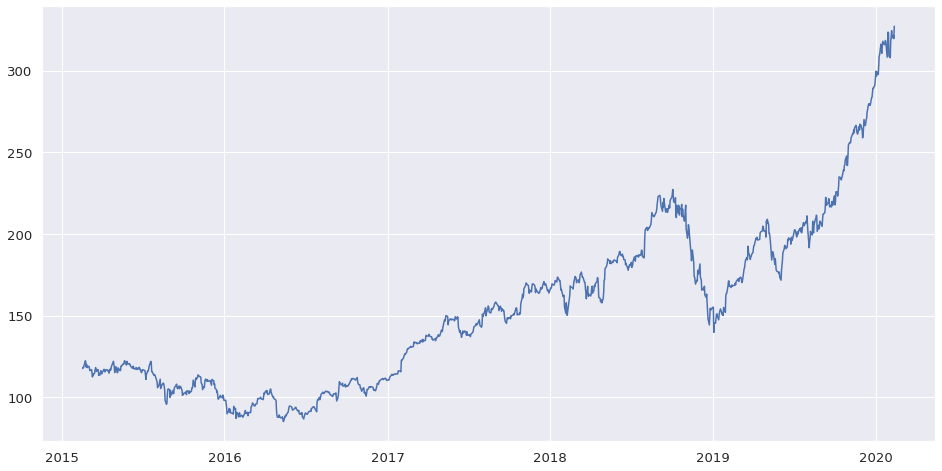

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.plot(data['Adj Close'], label='Close Price history')
plt.show(sns)

In [0]:
def build_model(data, training_days, training_itmes):
  dataset = data['Adj Close'].values.reshape(-1, 1)
  train = dataset[0:training_itmes,0]

  #converting dataset into x_train and y_train
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(dataset)

  x_train, y_train = [], []
  for i in range(training_days, len(train)):
      x_train.append(scaled_data[i-training_days:i, 0])
      y_train.append(scaled_data[i, 0])
  x_train, y_train = np.array(x_train), np.array(y_train)

  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(LSTM(units=50))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

  return model, scaler

In [6]:
training_days = 60
training_itmes = (int)(len(data) * 0.7) 
model, scaler = build_model(data, training_days, training_itmes)

879




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





 - 58s - loss: 9.9479e-04


In [13]:
#predicting 246 values, using past training_days from the train data
valid = data['Adj Close'].values.reshape(-1, 1)[training_itmes:,0]
inputs = data['Adj Close'][training_itmes - training_days:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(training_days, inputs.shape[0]):
    X_test.append(inputs[i-training_days:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
rms = np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

61.3742971695795

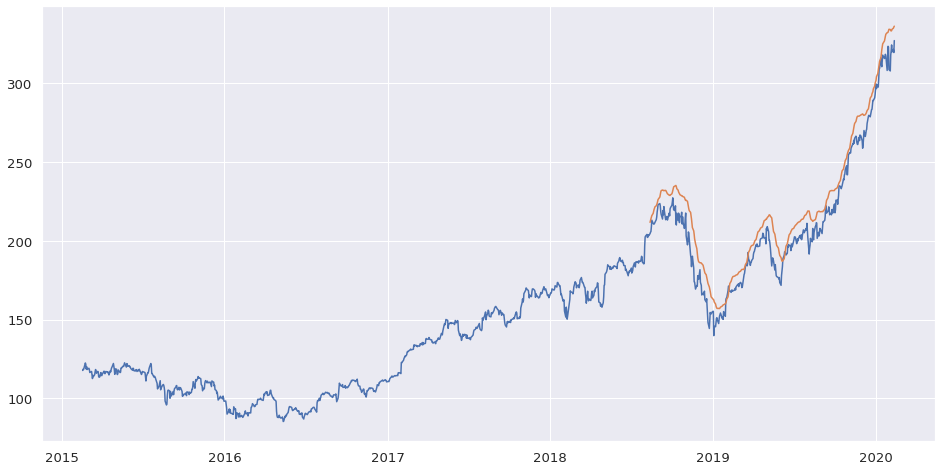

In [14]:
#for plotting
data.loc[training_itmes:, 'Predictions'] = closing_price[:,0]
plt.plot(data[['Adj Close','Predictions']])
plt.show()